## Using Latent Dirichlet Allocation and Topic Modeling to Gauge Uses for Chat-GPT

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import html
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

First, read in large dataset. This dataset is not uploaded to Github as it is too large, but please download it the link below, create a 'Data' file in the project directory, and upload it there.

https://www.kaggle.com/datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023

In [22]:
# Make dataframe local variable
data = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/Twitter Jan Mar 2.csv", encoding='UTF-8')

# Verify that the data is loaded
print(data.head(5))


                        date                   id  \
0  2023-03-29 22:58:21+00:00  1641213230730051584   
1  2023-03-29 22:58:18+00:00  1641213218520481805   
2  2023-03-29 22:57:53+00:00  1641213115684536323   
3  2023-03-29 22:57:52+00:00  1641213110915571715   
4  2023-03-29 22:57:26+00:00  1641213003260633088   

                                             content        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         0.0            0.0  
4         0.0            0.0  


# Data Cleaning

Begin data cleaning by dropping missing values and resetting index to make processing of remaining tweets possible.

In [23]:
# Check missing values in the 'content' column
missing_content = data[data['content'].isnull()]

# Drop rows with missing content
data.dropna(subset=['content'], inplace=True)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

You must first initialize data_subset as a truncated copy of the first half of the dataset. Later code will help write the cleaned data to a csv so it doesn't need to be instantiated as a variable every time.

In [28]:
# Create a new truncated subset of data
data_subset = data.head(250000).copy()

If the cleaned_data csv has already been created, read it in here.

In [ ]:
#If the data subset has already been created, run this block instead of cleaning repeatedly.
data_subset = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/cleaned_data.csv", encoding='UTF-8')

It's important to calculate descriptive statistics to get a better understanding of our data. Here are the descriptive statistics for the engagement variables and the length of the datasets being used.

In [40]:
# Calculate number of rows
data_len = len(data)

# Calculate descriptive statistics for like_count
like_count_stats = data['like_count'].describe()

# Calculate descriptive statistics for retweet_count
retweet_count_stats = data['retweet_count'].describe()

# Calculate num rows cleaned data
data_subset_len = len(data_subset)

print("All tweets length:", data_len)

print("\nDescriptive statistics for like_count:", like_count_stats)

print("\nDescriptive statistics for retweet_count:", retweet_count_stats)

print("\nClean tweets length:", data_subset_len)

All tweets length: 500030

Descriptive statistics for like_count: count    499974.000000
mean          7.123208
std         216.366469
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max       64094.000000
Name: like_count, dtype: float64

Descriptive statistics for retweet_count: count    499974.000000
mean          1.481523
std          46.254101
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       16080.000000
Name: retweet_count, dtype: float64

Clean tweets length: 250000


## Alternate Data Cleaning Tool

This is a more customizeable version of a tweet cleaning tool that can be customized to your liking. However, I chose to use the NLTK stopwords library instead because it was both quicker and more effective. Feel free to make use of this if you prefer. 

In [14]:
# Code to clean the data and write it to a new csv file


# Words to clean
words_to_clean = ["chatgpt", "ai", "gpt", "chat", "gpt4", "https", "artificialintelligence", "http", "like"]

# Instantiate an empty list to store cleaned tweets
clean_tweets = []

# Iterate over each tweet in data_subset
for tweet in data_subset['content']:
    
    # Manage HTML artifacts
    decoded_tweet = html.unescape(tweet)

    #Lowecase each tweet
    cleaned_tweet = decoded_tweet.lower()

    # Clean tweet by replacing specified words with spaces
    for word in words_to_clean:
        cleaned_tweet = cleaned_tweet.replace(word, '')
    # Replace special characters with spaces
    cleaned_tweet = cleaned_tweet.replace('\r',' ')
    cleaned_tweet = cleaned_tweet.replace('\n',' ')
    cleaned_tweet = cleaned_tweet.replace('. ',' ')
    cleaned_tweet = cleaned_tweet.replace(', ',' ')
    # Append cleaned tweet to the list
    clean_tweets.append(cleaned_tweet.strip())  # strip removes leading/trailing whitespaces

# Add cleaned tweets to data_subset
data_subset['clean_tweet'] = clean_tweets

# Remove duplicates based on similarity
similar_level = 85  # Sets baseline similarity level
duplicate_index = []  # Initializes list for tweet indices to remove

for original in range(len(data_subset)-1):
    print((original / len(data_subset) * 100), '%')
    for compared in range(original+1, len(data_subset)):
        if compared not in duplicate_index:
            if fuzz.ratio(data_subset['clean_tweet'][original], data_subset['clean_tweet'][compared]) >= similar_level:
                duplicate_index.append(compared)

# Drop duplicate tweets
data_subset.drop(duplicate_index, inplace=True)
data_subset.reset_index(drop=True, inplace=True)

# Write cleaned data to a new CSV file
data_subset.to_csv('data/data_5,000_rows.csv', index=False)

0.0 %
0.020929259104227712 %
0.041858518208455424 %
0.06278777731268313 %
0.08371703641691085 %
0.10464629552113855 %
0.12557555462536626 %
0.14650481372959395 %
0.1674340728338217 %
0.18836333193804938 %
0.2092925910422771 %
0.23022185014650481 %
0.25115110925073253 %
0.27208036835496024 %
0.2930096274591879 %
0.3139388865634157 %
0.3348681456676434 %
0.35579740477187105 %
0.37672666387609877 %
0.39765592298032654 %
0.4185851820845542 %
0.4395144411887819 %
0.46044370029300963 %
0.4813729593972373 %
0.5023022185014651 %
0.5232314776056928 %
0.5441607367099205 %
0.5650899958141482 %
0.5860192549183758 %
0.6069485140226036 %
0.6278777731268314 %
0.648807032231059 %
0.6697362913352868 %
0.6906655504395145 %
0.7115948095437421 %
0.7325240686479699 %
0.7534533277521975 %
0.7743825868564252 %
0.7953118459606531 %
0.8162411050648808 %
0.8371703641691084 %
0.8580996232733361 %
0.8790288823775638 %
0.8999581414817915 %
0.9208874005860193 %
0.9418166596902469 %
0.9627459187944746 %
0.9836751778

## Primary Data Cleaning Process

Download NLTK data for data cleaning.

In [20]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/scottpetersen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scottpetersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/scottpetersen/nltk_data...


True

Initialize a lemmatizer to remove unnecessary word variation:

In [ ]:
# Initialize NLTK's WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

Create a built-in list of stopwords and punctuation to be cleaned later using NLTK's libraries.

In [ ]:
# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

CUSTOM list of words to remove from the dataset. 

In [35]:
# Words to clean
words_to_clean = ["chatgpt", "ai", "gpt", "chat", "gpt4", "https", "artificialintelligence", "http", "like", "openai"]

Code to add a new column to the data subset called 'clean_tweet' that has been decoded with UTF-8, tokenized, lemmatized, and cleaned of custom word list.

In [36]:
# Function to preprocess a single tweet
def preprocess_tweet(tweet):
    # Decode HTML artifacts
    decoded_tweet = html.unescape(tweet)
    
    # Tokenize tweet
    tokens = word_tokenize(decoded_tweet.lower())
    
    # Remove stopwords and single-character tokens, and perform lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                      if token not in stop_words and token not in punctuation and len(token) > 2]
    
    # Remove specified words
    cleaned_tweet = ' '.join([word for word in cleaned_tokens if word not in words_to_clean])
    
    return cleaned_tweet

# Apply preprocessing to each tweet in the dataset
data_subset['clean_tweet'] = data_subset['content'].apply(preprocess_tweet)

Write cleaned dataset to a new csv in the 'Data' folder. This makes it easier to run the data as we no longer have to clean it every time. This method also ensures a consistent dataset. 

In [37]:
# Write cleaned data to a new CSV file
data_subset.to_csv('Data/cleaned_data.csv', index=False)

## LDA Model

Create an LDA model with the following parameters:

Max document frequency: 0.95 \
Min document frequency: 2 \
Num topics: 10 \
Random State: 1680 (Preserve for replicability) 

In [38]:
# Create a count vectorizer with specified parameters
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') 

# Transform newly cleaned tweets into a bag-of-words representation
bow_representation = vectorizer.fit_transform(data_subset['clean_tweet'])

# Set hyperparameter for num_topics
num_topics = 10

# Initialize LDA model and fit
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1680)
lda_model.fit(bow_representation)

# Get and print the list of topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])

Topic 1:
['gpt', 'model', 'language', 'api', 'new', 'access', 'version', 'plus', 'time', 'user']
Topic 2:
['google', 'bing', 'microsoft', 'bard', 'chatbot', 'search', 'new', 'know', 'elon', 'chatgpt4']
Topic 3:
['tech', 'web3', 'metaverse', 'world', 'iot', 'python', 'latest', 'gaming', 'marketing', 'ai']
Topic 4:
['technology', 'intelligence', 'artificial', 'midjourney', 'domain', 'innovation', 'machinelearning', 'aiart', 'art', 'generativeai']
Topic 5:
['human', 'elonmusk', 'data', 'asked', 'people', 'think', 'right', 'information', 'imagine', 'bias']
Topic 6:
['write', 'ask', 'question', 'answer', 'asked', 'using', 'code', 'text', 'use', 'day']
Topic 7:
['prompt', 'use', 'job', 'tool', 'using', 'help', 'student', 'work', 'chatbot', 'new']
Topic 8:
['know', 'make', 'use', 'people', 'writing', 'content', 'tool', 'need', 'work', 'using']
Topic 9:
['new', 'technology', 'business', 'microsoft', 'future', 'learn', 'youtube', 'blog', 'read', 'tool']
Topic 10:
['nft', 'crypto', 'airdrop', 'g

Create wordclouds for each topic:

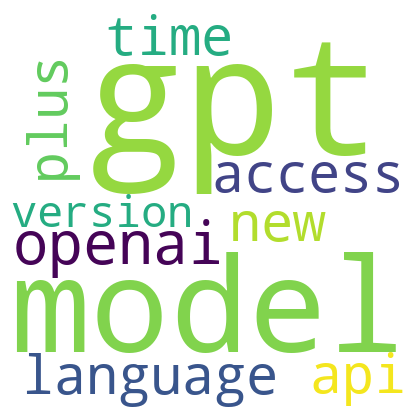

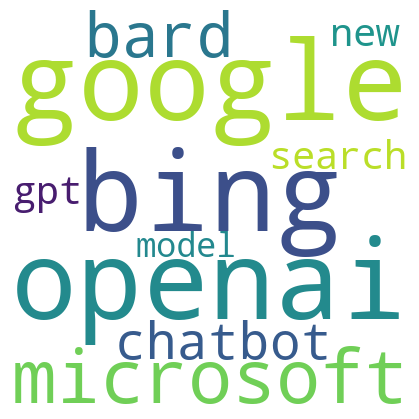

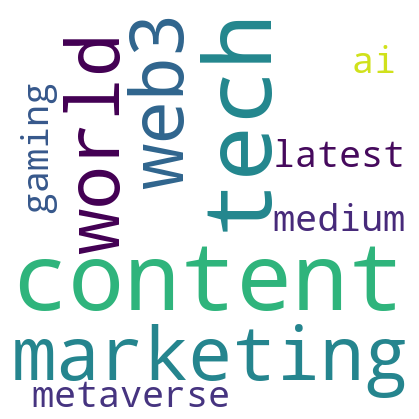

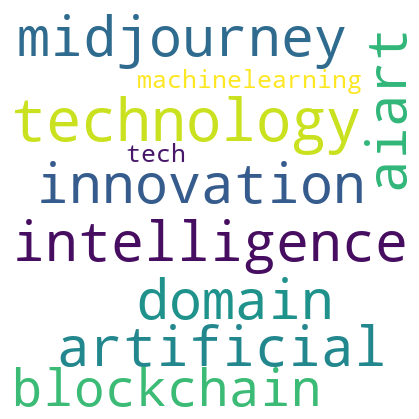

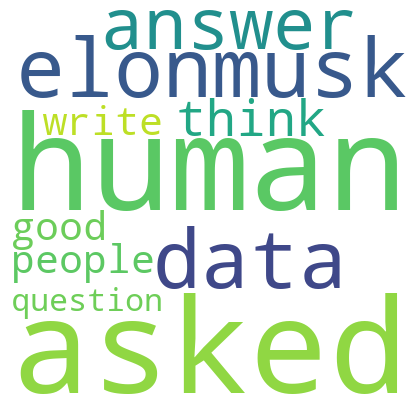

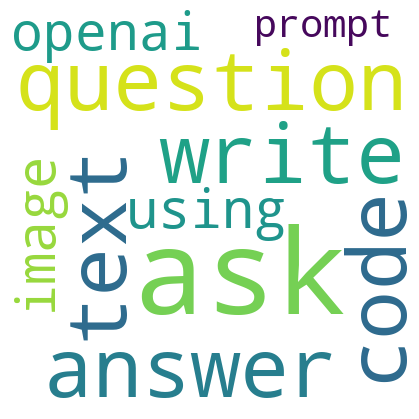

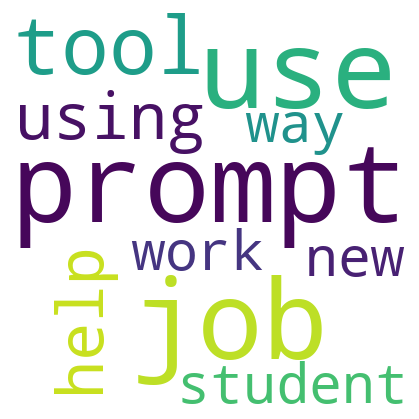

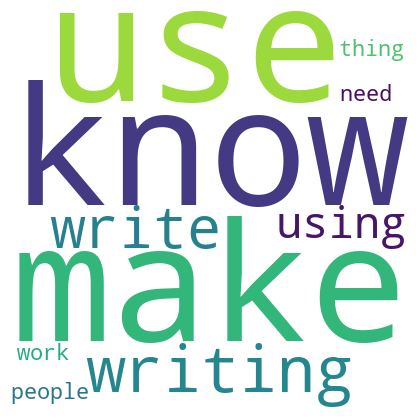

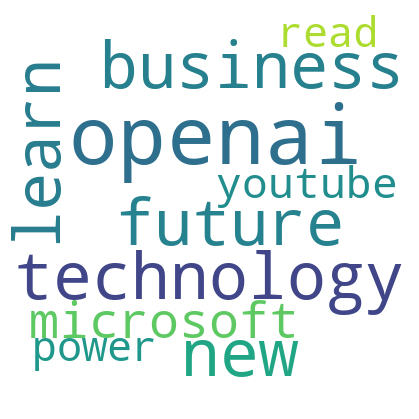

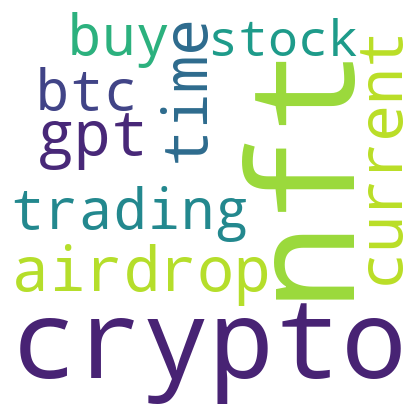

In [32]:
# Create the "Figures" directory if it doesn't exist
figures_dir = 'Figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    # Get top words for the topic
    top_words_indices = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_indices]  # Get actual words
    
    # Create word cloud object with smaller dimensions
    wordcloud = WordCloud(width = 400, height = 400,  # Adjust width and height
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(' '.join(top_words))
    
    # Plot word cloud
    plt.figure(figsize = (4, 4), facecolor = None)  # Adjust figure size
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    # Save the word cloud figure to the "Figures" directory
    fig_filename = os.path.join(figures_dir, f"topic_{topic_idx+1}_wordcloud.png")
    plt.savefig(fig_filename)  # Save word cloud as an image

    # Display word cloud
    plt.show() 

Topic modeling is not representative of engagement. Here, I have reordered each topic according to its engagement level based on likes and retweets. 

In [39]:
# Calculate average like count and average retweet count for each topic
topic_stats = pd.DataFrame(index=range(num_topics), columns=['Average Like Count', 'Average Retweet Count'])

for topic_idx, topic in enumerate(lda_model.components_):
    # Get indices of tweets belonging to the current topic
    topic_indices = lda_model.transform(bow_representation).argmax(axis=1) == topic_idx
    # Calculate average like count and average retweet count for tweets in this topic
    topic_like_count = data_subset.loc[topic_indices, 'like_count'].mean()
    topic_retweet_count = data_subset.loc[topic_indices, 'retweet_count'].mean()
    # Store the averages in the DataFrame
    topic_stats.loc[topic_idx] = [topic_like_count, topic_retweet_count]

# Sort topics based on average like count
sorted_topics_by_like = topic_stats.sort_values(by='Average Like Count', ascending=False)

# Sort topics based on average retweet count
sorted_topics_by_retweet = topic_stats.sort_values(by='Average Retweet Count', ascending=False)

# Display the sorted topics along with their associated average like count and average retweet count
print("\nTopics re-ranked by Average Like Count:")
for idx, row in sorted_topics_by_like.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")

print("\nTopics re-ranked by Average Retweet Count:")
for idx, row in sorted_topics_by_retweet.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")



Topics re-ranked by Average Like Count:
Topic 1: Avg Like Count=8.71875, Avg Retweet Count=1.5228033006244424
Topic 10: Avg Like Count=7.9017325144376205, Avg Retweet Count=3.2887524062700524
Topic 8: Avg Like Count=7.847466613646154, Avg Retweet Count=0.8716240845677171
Topic 6: Avg Like Count=7.615871907422187, Avg Retweet Count=1.1618615323224262
Topic 9: Avg Like Count=7.434402332361516, Avg Retweet Count=1.4936054421768707
Topic 7: Avg Like Count=6.6212507474900075, Avg Retweet Count=1.576118087684512
Topic 4: Avg Like Count=5.876476843100189, Avg Retweet Count=2.7197542533081287
Topic 2: Avg Like Count=5.6321988787587065, Avg Retweet Count=1.234724503086245
Topic 5: Avg Like Count=5.55000862515094, Avg Retweet Count=0.8962221838882181
Topic 3: Avg Like Count=4.000084331253162, Avg Retweet Count=1.221032214538708

Topics re-ranked by Average Retweet Count:
Topic 10: Avg Like Count=7.9017325144376205, Avg Retweet Count=3.2887524062700524
Topic 4: Avg Like Count=5.876476843100189, 

This was my attempt at using Principal Component Analysis. It probably won't appear in the final draft, so if I find no use for it, I will delete it. 

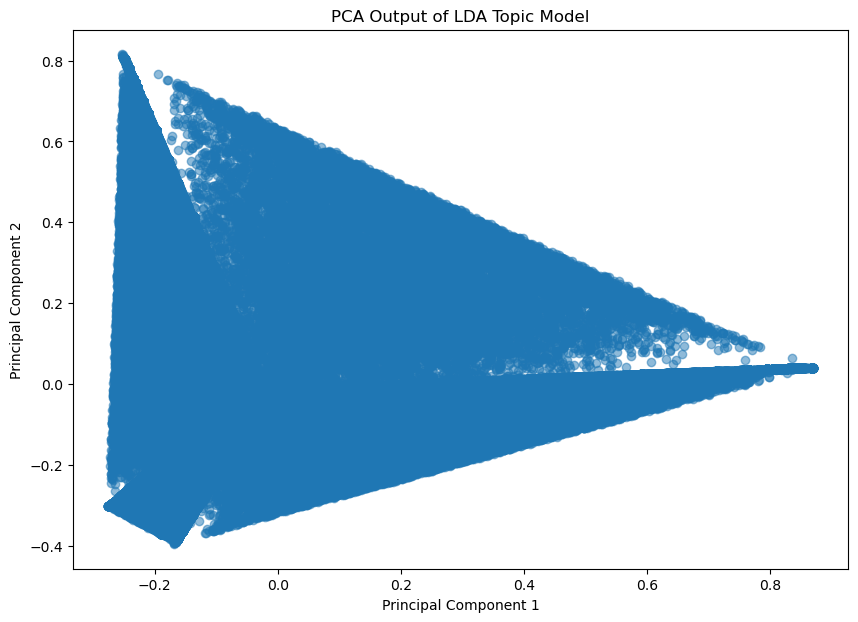

In [34]:
# Hyperparam for num_components for PCA model
num_components = 2  

# PCA model init
pca = PCA(n_components=num_components)

# Fit our PCA to the output of our LDA model
lda_output = lda_model.fit_transform(bow_representation)

pca_output = pca.fit_transform(lda_output)

# Create a figure to represent PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_output[:, 0], pca_output[:, 1], alpha=0.5)
plt.title('PCA Output of LDA Topic Model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()